In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
import multiprocessing
import gc
# my imports
from YelpNew import utils_yelp.py 
import sklearn.model_selection as model_selection
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,mean_squared_error,plot_confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('E:\\DBDA\\Project\\yelp_academic_dataset_review'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: invalid syntax (<ipython-input-2-252a77050ae1>, line 12)

# Yelp analysis
## Introduction
Yelp is company which is porviding the rating of hte restaurants. It is internet based rating forum, where people can write and rate restaurants aroud the globe. 
### Data
We will use reviews for sentiment analysis. This is classification problem. The load data are to big to be loaded at one, therefore we read line by line. Secondly, the each row is JSON but file is not JSON itself.
### Analysis
Since many of the Kaggle kernells trying fit model to some subset of data around 1 millinon. Therefore Kernell run quite long time. I will try Logistic regression, XGBoost, RandomForest to perform classification.
### Note
Helepr function can be found in utils_yelp.py, and test_utils_yelp.py for basic parametric test.

# 1. Load data


In [3]:
help(utils_yelp.loadJSON)

NameError: name 'utils_yelp' is not defined

In [3]:
data = pd.DataFrame(utils_yelp.loadJSON('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json',{'stars': [], 'text':[]},size=1000000))

# helping the RAM
gc.collect()
data.head(5)

,stars,text
0,2.0,"As someone who has worked with many museums, I..."
1,1.0,I am actually horrified this place is still in...
2,5.0,I love Deagan's. I do. I really do. The atmosp...
3,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g..."
4,4.0,"Oh happy day, finally have a Canes near my cas..."


# 2.EDA

The basic EDA is performed to find if there are extreme values and missing data.

## 2.1 Missing value

(1000000, 2)

stars    0
text     0
dtype: int64

,stars
count,1000000.000000
mean,3.716282
std,1.483008
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


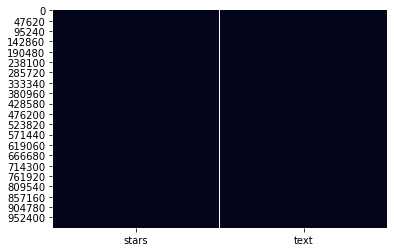

In [4]:
display(data.shape)
display(data.isnull().sum(axis=0))
display(data.describe())
sns.heatmap(data.isnull(), cbar=False)


As i seen from basic descritptive statistics and heatmat, there are no missing values. No treatment is required.

## 2.2 Descriptive statistics

In [5]:
display(data.describe())
display(data.info())


,stars
count,1000000.000000
mean,3.716282
std,1.483008
min,1.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   stars   1000000 non-null  float64
 1   text    1000000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 15.3+ MB


None

Basic descriptive statics showing, no outlayers since stars are between values 1 to 5.

## 2.3b Distribution of the stars


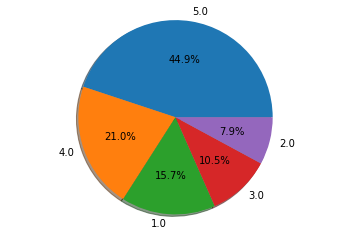

In [6]:

labels = data['stars'].value_counts().index
sizes = data['stars'].value_counts().values   
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax1.axis('equal')
plt.show()



It seems that there quite a lot possitive ( > 3 ) values over 65 %. We use Logistic regression.The **Naive Bayes** does not seem reasonable, because it is required to have proportion of negative and possitive data to be similar, that is arou 50 % each. 

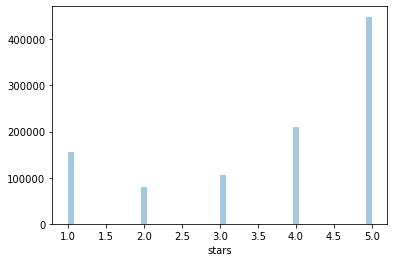

In [7]:
sns.distplot(data['stars'], kde=False)

# 3. Sentiment Analysis

## 3.1 Create labels

To have some balance in possitive and negative sentiment, values over 3 would be treated as possitive.

In [8]:
data['labels']  = np.where(data['stars']>3,1,0)
data.head(10)

,stars,text,labels
0,2.0,"As someone who has worked with many museums, I...",0
1,1.0,I am actually horrified this place is still in...,0
2,5.0,I love Deagan's. I do. I really do. The atmosp...,1
3,1.0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",0
4,4.0,"Oh happy day, finally have a Canes near my cas...",1
5,5.0,This is definitely my favorite fast food sub s...,1
6,5.0,"Really good place with simple decor, amazing f...",1
7,5.0,"Awesome office and staff, very professional an...",1
8,5.0,Most delicious authentic Italian I've had in t...,1
9,4.0,I have been here twice. Very nice and laid bac...,1


# 4 Preprocess data

## 4.1 Cleaning regex etc...

In [9]:
help(utils_yelp.text_clean)


Help on function text_clean in module utils_yelp:

text_clean(review)
    Process review into token
           remove following regex
    
        # remove hypertext links
        review = re.sub(r'https?:\/\/.*[
    ]*', '', review)
        # extract hash tag
        review = re.sub(r'@', '', review)
        # extract @
        review = re.sub(r'#', '', review)
        # extract numbers
        review = re.sub('[0-9]*[+-:]*[0-9]+', '', review)
        # extract '
        review = re.sub("'s", "", review)
    
        strip empty spaces and lower case words.
    
           :param review: the review.
           :rtype review: string
    
           :return list_of_words: list with words cleaned fro mthe review.



In [10]:

data['text']=data['text'].progress_apply(lambda x: utils_yelp.text_clean(x))
data.head(5)

,stars,text,labels
0,2.0,"as someone who has worked with many museums, i...",0
1,1.0,i am actually horrified this place is still in...,0
2,5.0,i love deagan. i do. i really do. the atmosphe...,1
3,1.0,"dismal, lukewarm, defrosted-tasting ""texmex"" g...",0
4,4.0,"oh happy day, finally have a canes near my cas...",1


## 4.2 Cleaning punctuation

In [11]:
help(utils_yelp.remove_punctuations)


Help on function remove_punctuations in module utils_yelp:

remove_punctuations(string)
    Remove puctuation.
    :param string:
    :return: string



In [12]:


    
data['text']=data['text'].progress_apply(lambda x: utils_yelp.remove_punctuations(x))
data.head(5) 

,stars,text,labels
0,2.0,as someone who has worked with many museums i ...,0
1,1.0,i am actually horrified this place is still in...,0
2,5.0,i love deagan i do i really do the atmosphere ...,1
3,1.0,dismal lukewarm defrostedtasting texmex glop\n...,0
4,4.0,oh happy day finally have a canes near my casa...,1


## 4.3 Cleaning stopwords
This takes very long since all sentences are split t the word a then reconstruct back to sentence.

In [13]:
help(utils_yelp.remove_stopwords)

Help on function remove_stopwords in module utils_yelp:

remove_stopwords(string, stop_words)
    Removing stop words.
    :param string:
    :param stop_words:
    :return: string



In [14]:
stop_words = stopwords.words('english')
# It takes to long for whole data set, therefore logic is shift to the CountVectoriser
#data['text']=data['text'].progress_apply(lambda x: utils_yelp.remove_stopwords(x,stop_words))
data.head(5)    

,stars,text,labels
0,2.0,as someone who has worked with many museums i ...,0
1,1.0,i am actually horrified this place is still in...,0
2,5.0,i love deagan i do i really do the atmosphere ...,1
3,1.0,dismal lukewarm defrostedtasting texmex glop\n...,0
4,4.0,oh happy day finally have a canes near my casa...,1


In [15]:
help(utils_yelp.stemming)

Help on function stemming in module utils_yelp:

stemming(str_input)
    Stemmer. Removing ing , ed etc....
    :param str_input: Input sentence
    :return: string of stemmed words



In [16]:
# takes really long need to imporve if i have time
data['text']=data['text'].progress_apply(lambda x: utils_yelp.stemming(x))
data.head(5) 

,stars,text,labels
0,2.0,as someon who ha work with mani museum i wa ea...,0
1,1.0,i am actual horrifi thi place is still in busi...,0
2,5.0,i love deagan i do i realli do the atmospher i...,1
3,1.0,dismal lukewarm defrostedtast texmex glop mumb...,0
4,4.0,oh happi day final have a cane near my casa ye...,1


# 5. Splitting data

Split data to train and test with size 0.7.****

In [17]:
X_train_corp, X_test_corp, y_train, y_test = model_selection.train_test_split(data['text'], data['labels'],test_size=0.3, random_state=42)
display(X_train_corp.shape)
display(X_train_corp.shape)
display(y_train.shape)
display(y_test.shape)

(700000,)

(700000,)

(700000,)

(300000,)

# 6. Modelling

In [18]:
# Prepare vector with frequencies
vector_count = CountVectorizer(min_df=100, ngram_range=(1, 1),stop_words=stop_words)
X_train = vector_count.fit(X_train_corp).transform(X_train_corp) 
X_test = vector_count.transform(X_test_corp)
print(X_train.shape) 

(700000, 9625)


# 6.1 Logistic Regrssion

In [19]:
logreg = LogisticRegression(max_iter=500,solver='liblinear').fit(X_train,y_train)
#print ("Accuracy: ", accuracy_score(y_test, logreg.predict(X_test)))
   
print(f"LG accuracy trainnig set: {logreg.score(X_train, y_train)}")
print(f"LG accuracy test set: {logreg.score(X_test, y_test)}")
print ("MSE: ", mean_squared_error(y_test, logreg.predict(X_test)))

LG accuracy trainnig set: 0.9086642857142857
LG accuracy test set: 0.90196
MSE:  0.09804


## Model summary

### Confusion Matrix

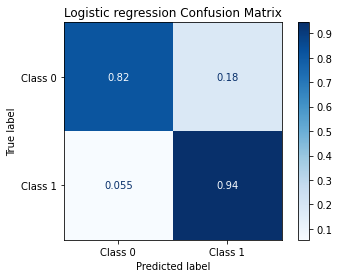

In [20]:
cm = plot_confusion_matrix(logreg, X_test, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
cm.ax_.set_title('Logistic regression Confusion Matrix');

In [21]:
help(utils_yelp.print_significant_words)

Help on function print_significant_words in module utils_yelp:

print_significant_words(logreg_coef=None, class_=None, count=100, count_vector=None, graph=True)
    :param logreg_coef: logistic regression coefficients
    :param class_:  0 is negative, 1 positive
    :param count: how many words to show, default to 100
    :param count_vector: counting vector
    :param graph: True ro print graph
    :rtype logreg_coef: numpy array
    :return:



In [22]:
help(utils_yelp.wc)

Help on function wc in module utils_yelp:

wc(words)
    :param words: list of word to make fancy graph
    :type words: list
    :return:



##  Most positive words

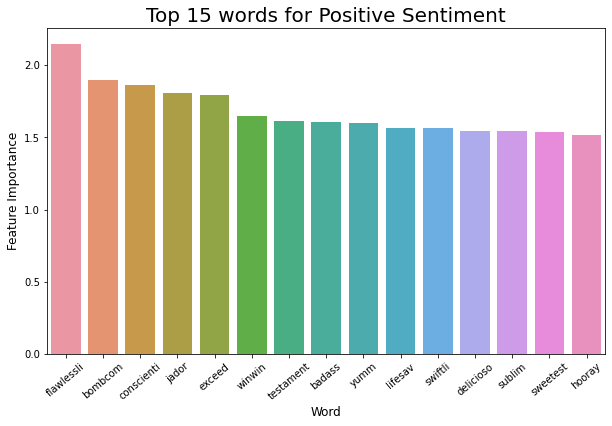

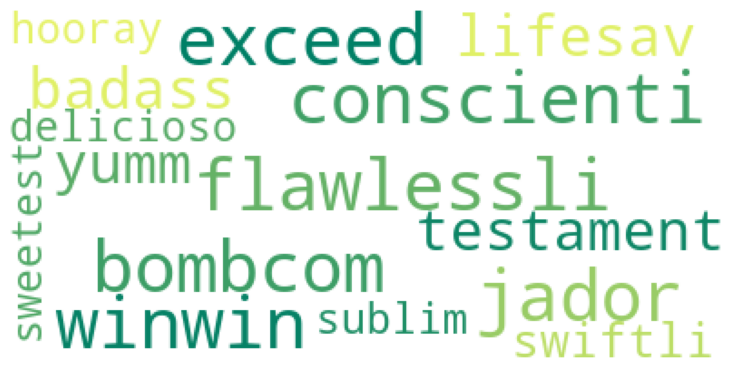

In [23]:


words = utils_yelp.print_significant_words(logreg.coef_[0],1,15,vector_count,True)
utils_yelp.wc(words)




##  Most negative words

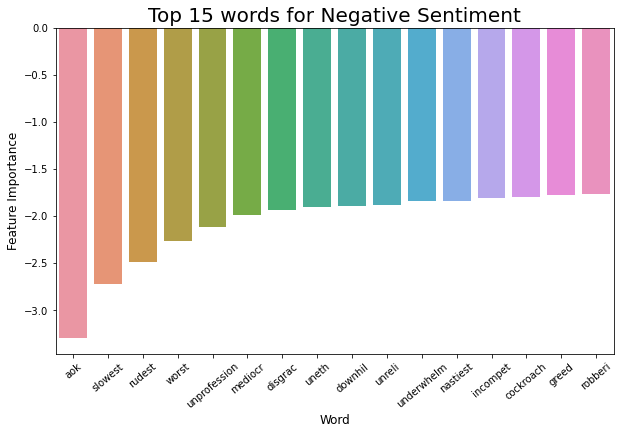

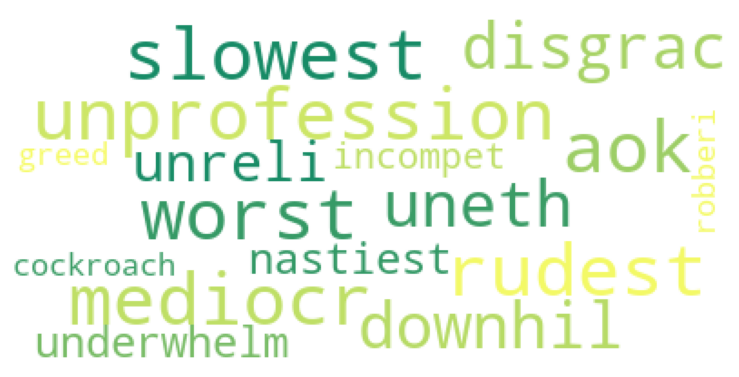

In [24]:
words = utils_yelp.print_significant_words(logreg.coef_[0],0,15,vector_count,True)
utils_yelp.wc(words)

# 

# 6.2 XGBoost

In [25]:

XGB_model = XGBClassifier(random_state=1)
XGB_model.fit(X_train, y_train)

print(f"XGBoost score - trainnig set: {XGB_model.score(X_train, y_train)}")
print(f"XGBoost score - test set: {XGB_model.score(X_test, y_test)}")
print ("MSE: ", mean_squared_error(y_test, XGB_model.predict(X_test)))

XGBoost score - trainnig set: 0.89153
XGBoost score - test set: 0.8831566666666667
MSE:  0.11684333333333333


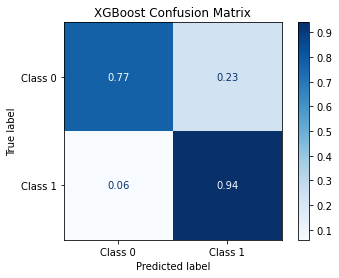

In [26]:
cm = plot_confusion_matrix(XGB_model ,X_test, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
cm.ax_.set_title('XGBoost Confusion Matrix');

# 6.3 Random Forest

In [27]:
score_tr = []
score_t = []
estim_depth = []
mse_tr = []
mse_t = []
max_d = 5
for i in range(1,max_d+1):
    print(i)
    random_forest_model = RandomForestClassifier(n_estimators=i,random_state=1)
    random_forest_model.fit(X_train, y_train)
    score_tr.append(random_forest_model.score(X_train, y_train))
    score_t.append(random_forest_model.score(X_test, y_test))
    mse_tr.append(mean_squared_error(y_train, random_forest_model.predict(X_train)))
    mse_t.append(mean_squared_error(y_test, random_forest_model.predict(X_test)))
    estim_depth.append(i)
    

1
2
3
4
5


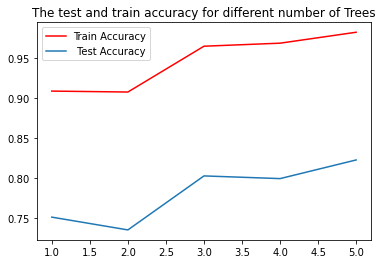

5


In [28]:
plt.figure()
plt.title('The test and train accuracy for different number of Trees')
plt.plot(range(1,max_d+1),score_tr,color='red',label='Train Accuracy')
plt.plot(range(1,max_d+1),score_t,label=' Test Accuracy')
plt.legend()
plt.show()
print(estim_depth[np.argmax(score_t)])

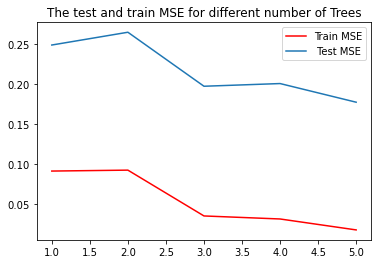

5


In [29]:
plt.figure()
plt.title('The test and train MSE for different number of Trees')
plt.plot(range(1,max_d+1),mse_tr,color='red',label='Train MSE')
plt.plot(range(1,max_d+1),mse_t,label=' Test MSE')
plt.legend()
plt.show()
print(estim_depth[np.argmin(mse_t)])

In [30]:
print(f"Random forest score - trainnig set: {score_tr[np.argmax(score_t)]}")
print(f"Random forest score - test set: {score_t[np.argmax(score_t)]}")
print ("MSE: ", mse_t[np.argmax(score_t)] )


Random forest score - trainnig set: 0.9823657142857143
Random forest score - test set: 0.82251
MSE:  0.17749


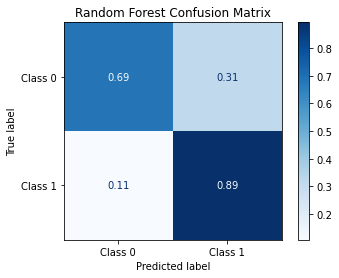

In [31]:
cm = plot_confusion_matrix(random_forest_model ,X_test, y_test,
                                 display_labels=['Class 0', 'Class 1'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
cm.ax_.set_title('Random Forest Confusion Matrix');

## 6.4 Pipeline LG

In [32]:
tfidf_vector = TfidfVectorizer(min_df=100,ngram_range=(1, 1),stop_words=stop_words
                       )

param_grid = [{
               'logreg_reg__penalty': ['l1', 'l2'], 
                
               'logreg_reg__max_iter':[500],
               'logreg_reg__C': [1.0, 10.0]},

             
                 ]


logreg_tfidf = Pipeline([
    ('vc_norm', tfidf_vector),
    ('logreg_reg', LogisticRegression(random_state=1, solver='saga'))

]
                       )

rf_tfidf = Pipeline([('vc_norm', tfidf_vector),
                     ('rf', RandomForestClassifier(random_state=1))])

gs_lr_tfidf = GridSearchCV(logreg_tfidf, param_grid,
                           scoring='accuracy',
                           cv=3,
                           verbose=1,
                           n_jobs=-1)

# Take long
gs_lr_tfidf.fit(X_train_corp, y_train)


print('Best LG parameter set: ' + str(gs_lr_tfidf.best_params_))
print('Best LG accuracy: %.3f' % gs_lr_tfidf.best_score_)






Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 35.6min finished


Best LG parameter set: {'logreg_reg__C': 1.0, 'logreg_reg__max_iter': 500, 'logreg_reg__penalty': 'l1'}
Best LG accuracy: 0.905


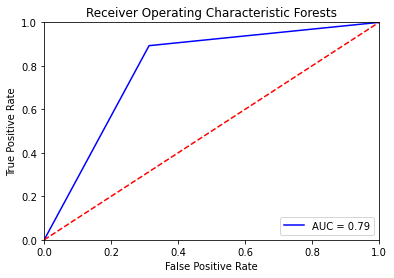

In [33]:

import sklearn.metrics as metrics
fpr, tpr, threshold = metrics.roc_curve(y_test, random_forest_model.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic Forests')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

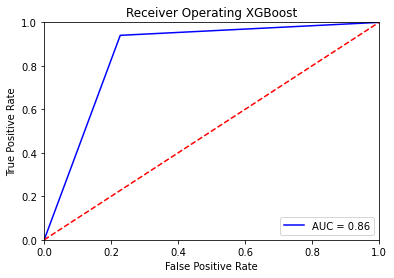

In [34]:
fpr, tpr, threshold = metrics.roc_curve(y_test, XGB_model.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating XGBoost')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

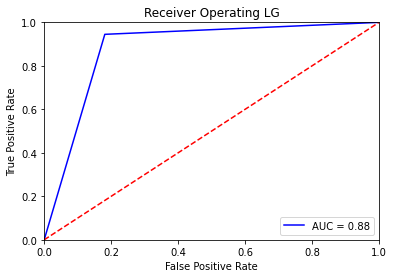

In [35]:
fpr, tpr, threshold = metrics.roc_curve(y_test, logreg.predict(X_test))
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating LG')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()